In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from simpegtorch.discretize import TensorMesh
from simpegtorch.simulation.resistivity import (
    DC3DCellCentered,
    SrcDipole,
    RxDipole,
    Survey,
)
from simpegtorch.simulation.base import DirectSolver, mappings
from simpegtorch.inversion import (
    BaseInversion,
    BaseInvProblem,
    BetaSchedule,
    TargetMisfit,
    BetaEstimate_ByEig,
)
from simpegtorch.data_misfit import L2DataMisfit
from simpegtorch.regularization import WeightedLeastSquares

from simpegtorch.utils import (
    get_indices_sphere,
    active_from_xyz
)

from simpegtorch.simulation.utils import (
    pseudo_locations,
    generate_dcip_sources_line,
    
)

# Set default dtype
torch.set_default_dtype(torch.float64)


In [2]:
# Generate some topography, taking this from simpeg examples 
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 100.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

topo_xyz = torch.cat([
    torch.tensor(x_topo).flatten().unsqueeze(1),
    torch.tensor(y_topo).flatten().unsqueeze(1),
    torch.tensor(z_topo).flatten().unsqueeze(1) 
], dim=1)

topo_xyz.shape

torch.Size([19881, 3])

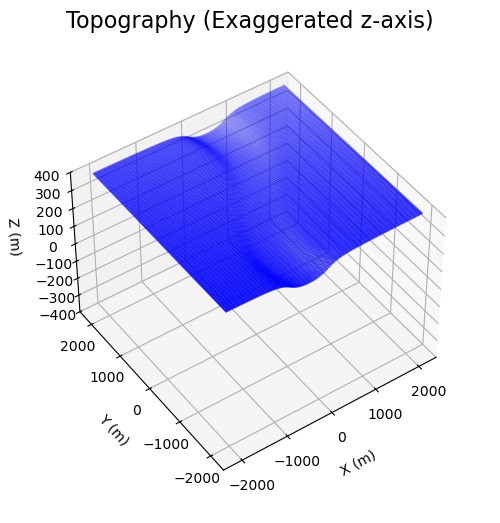

In [3]:
# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

In [4]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
data_type = "volt"
dimension_type = "3D"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]  # [x0, x1, y0, y1]
station_separation = 250.0
num_rx_per_src = 10

# The source lists for each line can be appended to create the source
# list for the whole survey.
source_list = []
for ii in range(0, len(end_locations_list)):
    source_list += generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = Survey(source_list)

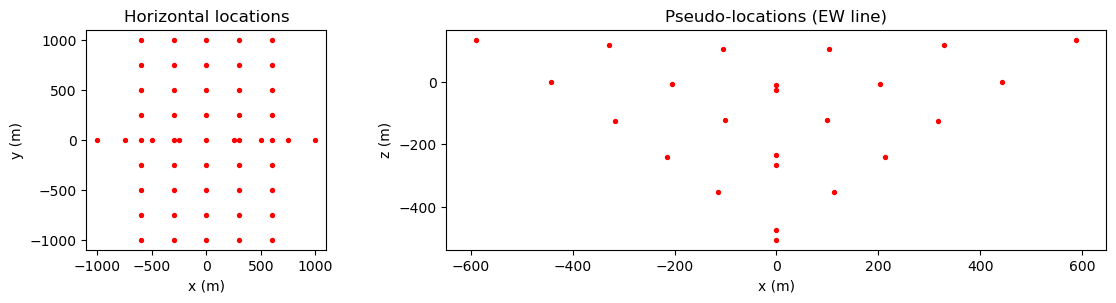

In [5]:
unique_locations = survey.unique_electrode_locations
fig = plt.figure(figsize=(12, 2.75))
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.8])
ax1.scatter(unique_locations[:, 0], unique_locations[:, 1], 8, "r")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Horizontal locations")

pseudo_locations_xyz = pseudo_locations(survey)
inds = pseudo_locations_xyz[:, 1] == 0.0
ax2 = fig.add_axes([0.4, 0.1, 0.55, 0.8])
ax2.scatter(pseudo_locations_xyz[inds, 0], pseudo_locations_xyz[inds, -1], 8, "r")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax2.set_title("Pseudo-locations (EW line)")
plt.show()

In [6]:
# Defining domain size and minimum cell size
dh = 50.0  # base cell width
dom_width_x = 2100.0  # domain width x
dom_width_y = 2100.0  # domain width y
dom_width_z = 500.0  # domain width z

# Number of base mesh cells in each direction
nbcx = int(dom_width_x / dh)  # num. base cells x
nbcy = int(dom_width_y / dh)  # num. base cells y
nbcz = int(dom_width_z / dh)  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TensorMesh([hx, hy, hz], origin="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + torch.tensor([0.0, 0.0, z_topo.max()])

In [7]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)
n_active = torch.sum(active_cells)
n_total = mesh.nC


Surface elevation range: 339.52 to 409.23 m (mean: 392.28 m)
Found 16766 active cells out of 17640 total cells


In [86]:
# Define conductivity values in S/m (take reciprocal for resistivities in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_total)

ind_conductor = get_indices_sphere(
    np.r_[-300.0, 0.0, 300.0], 100.0, mesh.cell_centers
)

ind_resistor = get_indices_sphere(
    np.r_[300.0, 0.0, 300.0], 100.0, mesh.cell_centers
)

conductivity_model[ind_conductor] = conductor_conductivity
conductivity_model[ind_resistor] = resistor_conductivity
conductivity_model[~active_cells] = air_conductivity



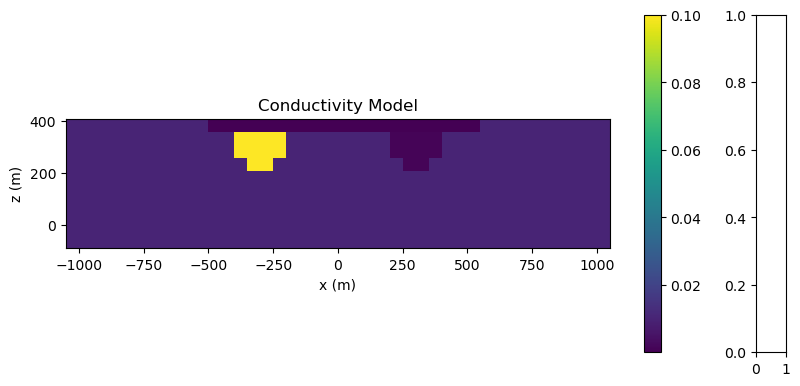

In [87]:
# Generate a mapping to ignore inactive cells in plot

fig = plt.figure(figsize=(10, 4.5))

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])  # Adjust y-limits based on mesh

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])


In [88]:
# Create mapping and PDE for forward modeling
sigma_true = mappings.BaseMapping(ground_parameters=torch.tensor(conductivity_model), active_cells=active_cells)
pde_true = DC3DCellCentered(mesh, survey, sigma_true, bc_type="Dirichlet")
solver_true = DirectSolver(pde_true)

Homogeneous Dirichlet is the natural BC for this CC discretization


In [89]:
# Generate clean data
torch.set_default_dtype(torch.float64)

with torch.no_grad():
    data_clean = solver_true.forward()


noise_std = 0.05 * torch.abs(data_clean)
noise = torch.normal(0.0, noise_std)
data_noisy = data_clean + noise
uncertainties = noise_std + 1e-6



In [90]:
# Setup the solver we will invert over
sigma_start = torch.ones(mesh.n_cells) *  1e-2
sigma_start[~active_cells] = air_conductivity
sigma_map_start = mappings.BaseMapping(sigma_start, active_cells=active_cells)
pde_start = DC3DCellCentered(mesh, survey, sigma_map_start, bc_type="Dirichlet")
solver_start = DirectSolver(pde_start)


Homogeneous Dirichlet is the natural BC for this CC discretization


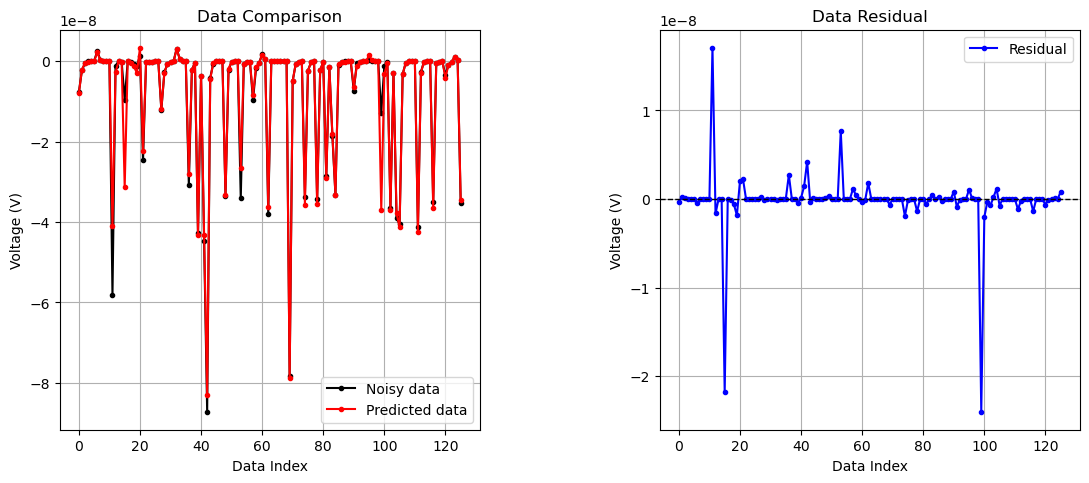

In [91]:
## plot the data initially for prior model
with torch.no_grad():
    data_start = solver_start.forward()
    residual_start = data_start - data_noisy
# make 2 plots, one with the data and the other with the residual
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1.plot(data_noisy.numpy(), "k.-", label="Noisy data")
ax1.plot(data_start.numpy(), "r.-", label="Predicted data")
ax1.set_xlabel("Data Index")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("Data Comparison")
ax1.legend()
ax1.grid()
ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2.plot(residual_start.numpy(), "b.-", label="Residual")
ax2.axhline(0.0, color="k", linestyle="--", linewidth=1)
ax2.set_xlabel("Data Index")
ax2.set_ylabel("Voltage (V)")
ax2.set_title("Data Residual")
ax2.legend()
ax2.grid()
plt.show()



In [92]:
# Setup inversion objectives and directives
data_misfit = L2DataMisfit(solver_start, data_noisy, 1/uncertainties)
reg_small = WeightedLeastSquares(
    mesh,
    mapping=sigma_map_start,
    alpha_s=1.0,
    alpha_x=0.0,
    alpha_y=0.0,
    alpha_z=0.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
)

optimizer = torch.optim.LBFGS(
    [sigma_map_start.trainable_parameters],
    max_iter=20,
    lr=1.0,
    line_search_fn="strong_wolfe",
)


inv_prob = BaseInvProblem(
    data_misfit, reg_small, optimizer, beta=1.0, max_iter=20
)

directives = [
    BetaEstimate_ByEig(),
    BetaSchedule(cooling_factor=2, cooling_rate=5.0),
    #TargetMisfit(chi_factor=1.0),
]

inversion = BaseInversion(inv_prob, directives)

In [93]:
sigma_recovered = inversion.run()

BetaEstimate: β set to 6.99e-09 (ratio = 1.0)
Running inversion with 2 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 2.93e-03 (φ_d = 1.46e-03, β×φ_m = 1.46e-03) 
Iter   1: φ = 1.76e-03 (φ_d = 2.95e-04, β×φ_m = 1.46e-03) 
Iter   2: φ = 1.63e-03 (φ_d = 1.68e-04, β×φ_m = 1.46e-03) 
Iter   3: φ = 1.59e-03 (φ_d = 1.27e-04, β×φ_m = 1.46e-03) 
Iter   4: φ = 1.55e-03 (φ_d = 8.38e-05, β×φ_m = 1.46e-03) 
BetaSchedule: β reduced from 6.99e-09 to 3.49e-09
Iter   5: φ = 8.03e-04 (φ_d = 7.15e-05, β×φ_m = 7.31e-04) 
Iter   6: φ = 7.86e-04 (φ_d = 5.51e-05, β×φ_m = 7.31e-04) 
Iter   7: φ = 7.79e-04 (φ_d = 4.76e-05, β×φ_m = 7.31e-04) 
Iter   8: φ = 7.57e-04 (φ_d = 2.61e-05, β×φ_m = 7.31e-04) 
Iter   9: φ = 7.48e-04 (φ_d = 1.73e-05, β×φ_m = 7.31e-04) 
BetaSchedule: β reduced from 3.49e-09 to 1.75e-09
Iter  10: φ = 3.76e-04 (φ_d = 1.02e-05, β×φ_m = 3.65e-04) 
Iter  11: φ = 3.70e-04 (φ_d = 4.57e-06, β×φ_m = 3.65e-04) 
Iter  12: φ = 3.69e-04 (φ_d = 3.50e-06, β×φ_m = 3.65e-04) 
Iter  13: φ = 3.6

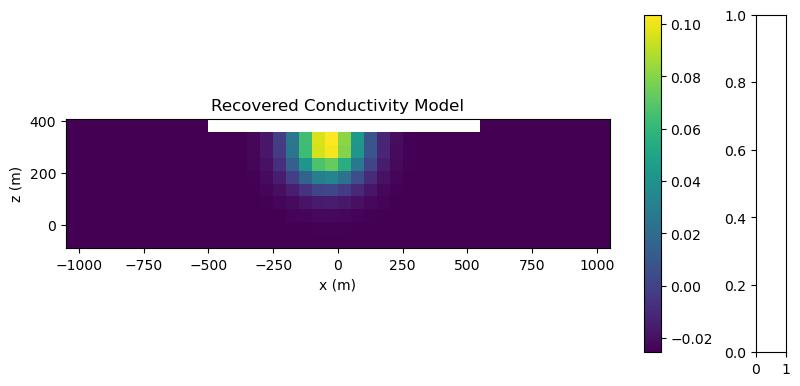

In [101]:
## plot the recovered model
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
sigma_plotting = sigma_recovered.forward().detach().numpy()
sigma_plotting[~active_cells] = np.nan
mesh.plot_slice(
    sigma_plotting,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])  # Adjust y-limits based on mesh
ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
plt.show()


Homogeneous Dirichlet is the natural BC for this CC discretization


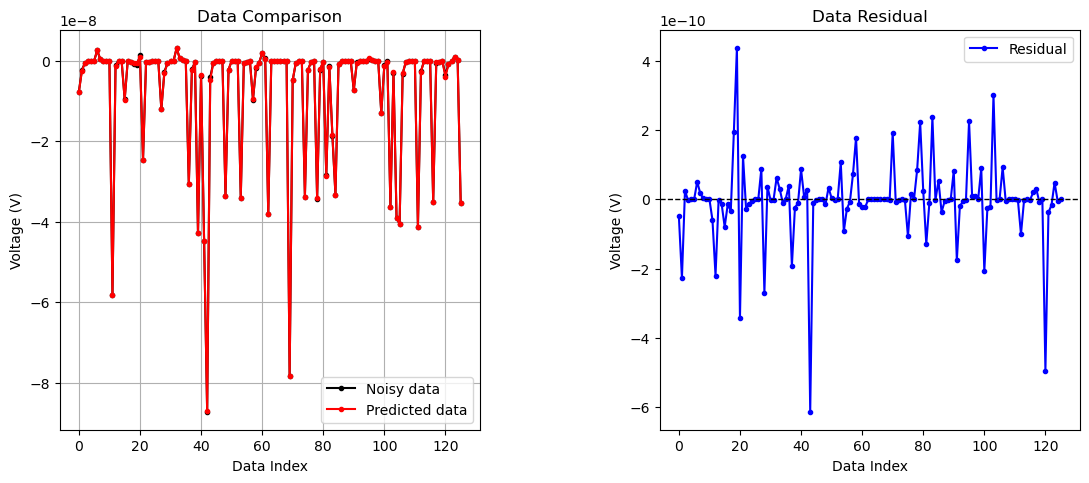

In [95]:
## Plot the residuals
with torch.no_grad():
    pde_recovered = DC3DCellCentered(mesh, survey, sigma_recovered, bc_type="Dirichlet")
    solver_recovered = DirectSolver(pde_recovered)
    data_recovered = solver_recovered.forward()
    residual_recovered = data_recovered - data_noisy
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1.plot(data_noisy.numpy(), "k.-", label="Noisy data")
ax1.plot(data_recovered.numpy(), "r.-", label="Predicted data")
ax1.set_xlabel("Data Index")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("Data Comparison")
ax1.legend()
ax1.grid()
ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2.plot(residual_recovered.numpy(), "b.-", label="Residual")
ax2.axhline(0.0, color="k", linestyle="--", linewidth=1)
ax2.set_xlabel("Data Index")

ax2.set_ylabel("Voltage (V)")
ax2.set_title("Data Residual")
ax2.legend()

In [122]:
## create a new neural mapping
from simpegtorch.simulation.base.mappings import BaseMapping
class ParameterizedMapping(torch.nn.Module):
    def __init__(self, mesh, active_cells):
        super(ParameterizedMapping, self).__init__()
        self.mesh = mesh
        self.active_cells = active_cells
        self.background_parameter = 1e-2
        n_rbfs = 2
        self.rbfs_centers = torch.nn.Parameter(torch.randn(n_rbfs, 3) * 10.0) + torch.tensor([0.0, 0.0, 300.0])
        self.rbfs_widths = torch.nn.Parameter(torch.ones(n_rbfs) * 100.0)
        self.rbfs_amplitudes = torch.nn.Parameter(torch.ones(n_rbfs) * 10)

    def ground_parameters(self):
        # Compute the ground parameters based on RBFs
        cell_centers = self.mesh.cell_centers
        params = self.background_parameter * torch.ones(cell_centers.shape[0])
        for i in range(self.rbfs_centers.shape[0]):
            rbf = self.rbfs_amplitudes[i] * torch.exp(-torch.sum((cell_centers - self.rbfs_centers[i])**2, dim=1) / (2 * self.rbfs_widths[i]**2))
            params += rbf
        params[~self.active_cells] = 1e-8
        return params
        

    def forward(self):
        ## Calculate ground parameters as sum of RBFs
        return self.ground_parameters()
    


In [123]:
sigma_map_neural = ParameterizedMapping(mesh, active_cells=active_cells)
## Initialize the weights to give the starting model
with torch.no_grad():
    def initialize_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

    sigma_map_neural.apply(initialize_weights)


pde_start = DC3DCellCentered(mesh, survey, sigma_map_neural, bc_type="Dirichlet")
solver_start = DirectSolver(pde_start)

Homogeneous Dirichlet is the natural BC for this CC discretization


In [134]:
# Setup inversion objectives and directives
data_misfit = L2DataMisfit(solver_start, data_noisy, 1/uncertainties)
reg_small = WeightedLeastSquares(
    mesh,
    mapping=sigma_map_start,
    alpha_s=0.0,
    alpha_x=0.0,
    alpha_y=0.0,
    alpha_z=0.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
)

optimizer = torch.optim.Adam(
    sigma_map_neural.parameters(),
    lr=0.01,
)



inv_prob = BaseInvProblem(
    data_misfit, reg_small, optimizer, beta=1.0, max_iter=200
)

directives = [
    #TargetMisfit(chi_factor=1.0),
]

inversion = BaseInversion(inv_prob, directives)

In [135]:
sigma_recovered = inversion.run()

Running inversion with 0 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 4.66e-02 (φ_d = 4.66e-02, β×φ_m = 0.00e+00) 
Iter   1: φ = 4.57e-02 (φ_d = 4.57e-02, β×φ_m = 0.00e+00) 
Iter   2: φ = 4.48e-02 (φ_d = 4.48e-02, β×φ_m = 0.00e+00) 
Iter   3: φ = 4.39e-02 (φ_d = 4.39e-02, β×φ_m = 0.00e+00) 
Iter   4: φ = 4.30e-02 (φ_d = 4.30e-02, β×φ_m = 0.00e+00) 
Iter   5: φ = 4.21e-02 (φ_d = 4.21e-02, β×φ_m = 0.00e+00) 
Iter   6: φ = 4.12e-02 (φ_d = 4.12e-02, β×φ_m = 0.00e+00) 
Iter   7: φ = 4.03e-02 (φ_d = 4.03e-02, β×φ_m = 0.00e+00) 
Iter   8: φ = 3.95e-02 (φ_d = 3.95e-02, β×φ_m = 0.00e+00) 
Iter   9: φ = 3.86e-02 (φ_d = 3.86e-02, β×φ_m = 0.00e+00) 
Iter  10: φ = 3.78e-02 (φ_d = 3.78e-02, β×φ_m = 0.00e+00) 
Iter  11: φ = 3.70e-02 (φ_d = 3.70e-02, β×φ_m = 0.00e+00) 
Iter  12: φ = 3.61e-02 (φ_d = 3.61e-02, β×φ_m = 0.00e+00) 
Iter  13: φ = 3.53e-02 (φ_d = 3.53e-02, β×φ_m = 0.00e+00) 
Iter  14: φ = 3.45e-02 (φ_d = 3.45e-02, β×φ_m = 0.00e+00) 
Iter  15: φ = 3.38e-02 (φ_d = 3.38e-02, β×φ_m

KeyboardInterrupt: 

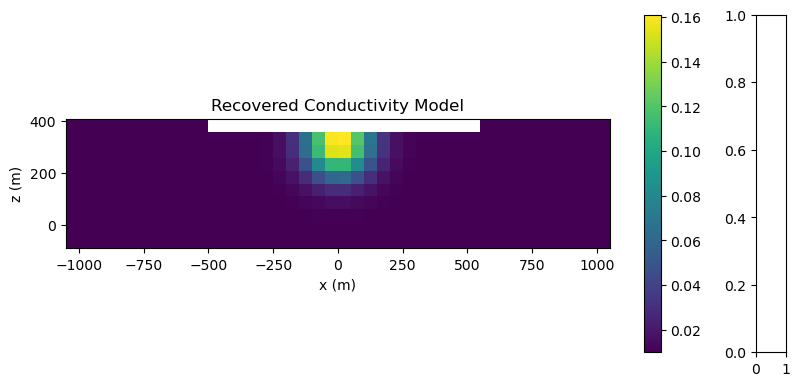

In [136]:
## plot the recovered model
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
sigma_plotting = sigma_map_neural.forward().detach().numpy()
sigma_plotting[~active_cells] = np.nan
mesh.plot_slice(
    sigma_plotting,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])  # Adjust y-limits based on mesh
ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
plt.show()
